# Loading polarization dataset and training a simple neural network

In this notebook, we show how to load our "processed" dataset, and give a simple example of how to use it to train a simple convolutionnal neural network that can predict the Sun's elevation based on a degree of polarization image. 

On a second part of the code, and example showing and using annotated data is presented that allow to train a similar network on all sky types, and then to choose only a specific sky type for validation. Even if on some classes there are too few data to have a siginifcant result (like in "dark" data), it seems to show that it is easier for the network to predict elevation from clear sky DOP than cloudy ones, which seems logical.

This notebook is courtesy of Thomas Kronland-Martinet and Fauzi Akbar

## Packages imports

In [2]:
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
from tqdm import tqdm
from torch.nn.functional import mse_loss

### Device for running code

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
#device="cpu" #force using CPU, comment if you want to be able to use GPU
print(f"Using {device} device")


Using cuda device


## Parameters

`data_dir` : Directory of the dataset \
`data_description_file` : File describing path to data folder and features for each measurement. In each folder, 11 numpy images can be loaded 

- image.npy, the raw pixel intensity image
- AOP_B.npy, the blue chanel processed angle of polarization
- AOP_Gb.npy, the green chanel (on the same rows as the blue chanel) processed angle of polarization
- AOP_Gr.npy, the green chanel (on the same rows as the red chanel) processed angle of polarization
- AOP_R.npy, the red chanel processed angle of polarization
- AOP_s.npy, the corresponding simulated image of the angle of polarization based on Rayleigh scattering model
- DOP_B.npy, the blue chanel processed degree of polarization
- DOP_Gb.npy, the green chanel (on the same rows as the blue chanel) processed degree of polarization
- DOP_Gr.npy, the green chanel (on the same rows as the red chanel) processed degree of polarization
- DOP_R.npy, the red chane processed degree of polarization
- DOP_s.npy, the corresponding simulated image of the degree of polarization based on Rayleigh scattering model 

`scale` : Dataset scale. 1 mean 100% of the dataset - set 0.1 (10%) for tests\
`batch_size` : batch size for data loader \
`num_epoch` : number of epoch for training \
`learning_rate` : learning rate for optimizer 

In [4]:
data_dir              = '/scratch/lpoughon/PolarizedDatabaseProcessedM'
data_description_file = 'all_days.csv'

scale = 0.1
batch_size = 16
num_epoch = 10
learning_rate = 1e-3

## Load data 

### Data description display

In [5]:
df = pd.read_csv(os.path.join(data_dir, data_description_file)).sample(frac = 1)

### Create, load dataset and split it into train and test

In [6]:
class PolarizationDataset(Dataset):
    def __init__(self, data_dir, data_description_file, transform=None, target_transform=None):
        #sample(frac = scale, random_state=1) is used to sample the dataset in a reproducible way
        self.data_description_file = pd.read_csv(os.path.join(data_dir, data_description_file)).sample(frac = scale, random_state=1)
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __getitem__(self, idx):
        DoLP_exp = os.path.join(self.data_dir, self.data_description_file.iloc[idx, 0], 'AOP_B.npy')
        DoLP_simu = os.path.join(self.data_dir, self.data_description_file.iloc[idx, 0], 'AOP_s.npy')
        Sun_el = np.float32(90-self.data_description_file.iloc[idx, 7])
        
        ## DoLP data already normalized

        imageDoLP_exp = torch.from_numpy(np.load(DoLP_exp)).unsqueeze(0).float()
        imageDoLP_simu = torch.from_numpy(np.load(DoLP_simu)).unsqueeze(0).float()
        
        # replace Nan values to zero for easy calculation. 
        # This could be managed in a better way 

        imageDoLP_exp = torch.nan_to_num(imageDoLP_exp) 
        imageDoLP_simu = torch.nan_to_num(imageDoLP_simu)
        
        if self.transform:
            imageDoLP_exp = self.transform(imageDoLP_exp)
            imageDoLP_simu = self.transform(imageDoLP_simu)

        if self.target_transform:
            Sun_el = self.target_transform(Sun_el)
            
        
        return imageDoLP_exp, imageDoLP_simu, Sun_el
    
    def __len__(self):
        return len(self.data_description_file)
    

In [7]:
dataset = PolarizationDataset(data_dir, data_description_file)
print(len(dataset))

#split data into train and te
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# generator : seed used to randomly split data into train and test set in a reproducible way
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(1))

trainloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)


3996


### Display dataset

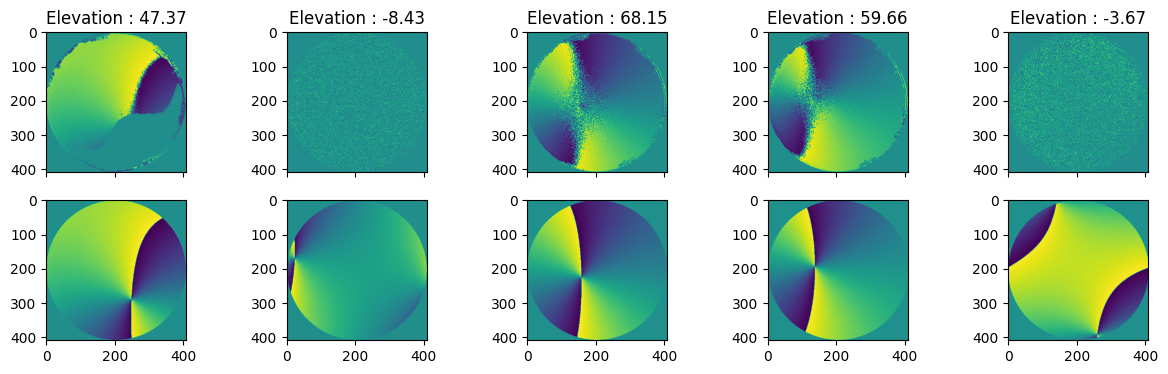

In [8]:
DoLP_exp_features, DoLP_simu_features, el_features = next(iter(trainloader))

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(15,4))
for i in range(5):
    ax[0,i].imshow(DoLP_exp_features[i].squeeze())
    ax[1,i].imshow(DoLP_simu_features[i].squeeze())
    ax[0,i].set_title("Elevation : %.2f" % el_features[i].item())

## Load and train convolutional neural network for Sun elevation estimation

In [9]:
class CNNnetwork(nn.Module):
    def __init__(self):
        super(CNNnetwork, self).__init__()
        self.conv1 = nn.Conv2d(1,5, kernel_size=5)
        self.conv2 = nn.Conv2d(5,10, kernel_size=5)
        self.mp = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(98010, 2000)
        self.fc2 = nn.Linear(2000,500)
        self.fc3 = nn.Linear(500,1)
    def forward(self,x):
        x = x.view(-1,1,409,409)
        in_size = x.size(0)
        x = F.relu(self.mp(self.conv1(x)))
        x = F.relu(self.mp(self.conv2(x)))
        x = x.view(in_size, -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
CNNnet = CNNnetwork()
CNNnet = CNNnet.to(device)
print(CNNnet)

CNNnetwork(
  (conv1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (mp): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=98010, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=1, bias=True)
)


In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, comp_device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    num_batches = len(dataloader)
    train_loss = 0
    loop = tqdm(dataloader)
    for batch, (X,Xs,y) in enumerate(loop):
        # Compute prediction and loss
        X = X.to(comp_device)
        y = y.to(comp_device)
                
        pred = model(X).squeeze(1)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()
        
        loop.set_description("Training")
        loop.set_postfix(loss=train_loss/(batch+1))
    
    train_loss /= num_batches
    return train_loss

def test_loop(dataloader, model, loss_fn,comp_device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        loop = tqdm(dataloader)
        for batch, (X,Xs,y) in enumerate(loop):
            X = X.to(comp_device)
            y = y.to(comp_device)
            
            pred = model(X).squeeze(1)
            loss = loss_fn(pred, y)
            
            test_loss+= loss.item()
            
            loop.set_description("Testing")
            loop.set_postfix(loss=test_loss/(batch+1))
    test_loss /= num_batches
    #print(f"Avg loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(CNNnet.parameters(), lr=learning_rate)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0
best_test_loss = 1_000_000.



train_loss_list = []
test_loss_list = []
for t in range(num_epoch):
    print(f"Epoch [{t+1}/{num_epoch}]\n-------------------------------")
    loss = train_loop(trainloader, CNNnet, criterion, optimizer, device)
    test_loss = test_loop(testloader, CNNnet, criterion, device)
    train_loss_list.append(loss)
    test_loss_list.append(test_loss)
    
    # Track best performance, and save the model's state
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        #denoising_model_path = 'Model_saved_parameters/CNNnet_{}_{}'.format(timestamp, epoch_number)
        #torch.save(CNNnet_.state_dict(), denoising_model_path)
    epoch_number += 1

print("Done!")
plt.plot(range(num_epoch),train_loss_list, range(num_epoch), test_loss_list)

Epoch [1/10]
-------------------------------


  0%|                                                                                                                                                                              | 0/200 [00:00<?, ?it/s]

### Display test set elevation estimation results

In [ ]:
DoLP_exp_features, DoLP_simu_features, el_features = next(iter(testloader))
DoLP_exp_features = DoLP_exp_features.to(device)

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(15,4))
for i in range(5):
    ax[0,i].imshow(DoLP_exp_features[i].squeeze().cpu())
    ax[1,i].imshow(DoLP_simu_features[i].squeeze())
    ax[0,i].set_title("Elevation : {:.2f}\nElevation_nn : {:.2f}".format(el_features[i].item(), CNNnet(DoLP_exp_features)[i].item()))


# Add the annotations file to make a new dataset

In [10]:
user_labels={'dark_sky': 'n',
 'clear_sky': 'c',
 'mist': 'm',
 'few_clouds': 'f',
 'scattered_clouds': 's',
 'broken_clouds': 'b',
 'overcast_clouds': 'o'}

In [11]:
import os
out_path="/scratch/lpoughon/PolarizedDatabaseM/"
dirs = os.listdir( out_path ) # Listing Files
dirs_files=[]
for file in dirs:
    if file[-7:]=='raw.npy': # Keeping only ones with ".npy" files. 
        dirs_files.append(file)
dirs_files.sort() #We sort the files in alphabetical order. 
# Since the format is YYYY-MM-DDTHH-mm-ss.npy, the files are sorted in chronological order.

### Show which days are annotated so far, and then display an overview figure with sky condition over the month :

In [12]:
dirs_ann = os.listdir( out_path ) # Listing Files
dirs_ann_files=[]
for file in dirs_ann:
    if file[-19:]=='raw_annotations.npy': # Keeping only ones with ".npy" files. 
        dirs_ann_files.append(file)
dirs_ann_files.sort() #We sort the files in alphabetical order. 
#print(dirs_ann_files)

In [13]:
liste_dates=[]
for i in range(len(dirs_files)):
    rec=dirs_files[i].split('_raw.npy')[0]+'_raw_annotations.npy'
    liste_dates.append(dirs_files[i].split('_raw.npy')[0])
    if rec in dirs_ann_files:
        print(i," ",dirs_files[i]," ",rec)
    else:
        print(i," ",dirs_files[i])

0   2022-07-06_raw.npy   2022-07-06_raw_annotations.npy
1   2022-07-07_raw.npy   2022-07-07_raw_annotations.npy
2   2022-07-08_raw.npy   2022-07-08_raw_annotations.npy
3   2022-07-09_raw.npy   2022-07-09_raw_annotations.npy
4   2022-07-10_raw.npy   2022-07-10_raw_annotations.npy
5   2022-07-11_raw.npy   2022-07-11_raw_annotations.npy
6   2022-07-12_raw.npy   2022-07-12_raw_annotations.npy
7   2022-07-13_raw.npy   2022-07-13_raw_annotations.npy
8   2022-07-14_raw.npy   2022-07-14_raw_annotations.npy
9   2022-07-15_raw.npy   2022-07-15_raw_annotations.npy
10   2022-07-16_raw.npy   2022-07-16_raw_annotations.npy
11   2022-07-17_raw.npy   2022-07-17_raw_annotations.npy
12   2022-07-18_raw.npy   2022-07-18_raw_annotations.npy
13   2022-07-19_raw.npy   2022-07-19_raw_annotations.npy
14   2022-07-20_raw.npy   2022-07-20_raw_annotations.npy
15   2022-07-21_raw.npy   2022-07-21_raw_annotations.npy
16   2022-07-22_raw.npy   2022-07-22_raw_annotations.npy
17   2022-07-23_raw.npy   2022-07-23_raw_

In [14]:
dirs_ann = os.listdir( out_path ) # Listing Files
dirs_ann_files=[]
for file in dirs_ann:
    if file[-19:]=='raw_annotations.npy': # Keeping only ones with ".npy" files. 
        dirs_ann_files.append(file)
dirs_ann_files.sort() #We sort the files in alphabetical order. 
#print(dirs_ann_files)

In [15]:
import numpy as np
from datetime import datetime, timedelta


def mosaique_meteos(dirs_ann_files,user_labels):
    start_hour=6
    end_hour=22
    
    liste_dates=[]
    for filen in dirs_files:
        liste_dates.append(filen.split("_raw")[0])
    print(liste_dates)
    a=np.full((97,len(liste_dates)), 'missing')
    
    for file in dirs_ann_files:
        print(file)
        date=file.split("_raw")[0]
        id_date=np.where(np.array(liste_dates)==date)[0][0]
        input_array=np.load(out_path+file,allow_pickle=True)
        #input_array=np.array([[None,None]])
    

        # Function to convert timestamp to datetime object
        def parse_timestamp(timestamp):
            return datetime.strptime(timestamp, '%Y-%m-%dT%H-%M-%S')


        current_date = parse_timestamp(input_array[0, 0]).replace(hour=0, minute=0, second=0, microsecond=0)
        start_time = current_date + timedelta(hours=6)
        end_time = current_date + timedelta(hours=22)
        time_step = timedelta(minutes=10)
        current_time = start_time
        result_array = []

        while current_time <= end_time:
            timestamp_str = current_time.strftime('%Y-%m-%dT%H-%M-%S')
            # Find the nearest timestamp in the input array
            nearest_timestamp = min(input_array[:, 0], key=lambda x: abs(parse_timestamp(x) - current_time))
            if parse_timestamp(nearest_timestamp) >= current_time and parse_timestamp(nearest_timestamp) <= current_time + time_step:
                color = input_array[input_array[:, 0] == nearest_timestamp, 1][0]
                result_array.append([timestamp_str, color])
            else:
                result_array.append([timestamp_str, 'missing'])
            current_time += time_step


        result_array=np.array(result_array)

        a[:,id_date]=(np.array(result_array)[:,1])
        
    return a

['2022-07-06', '2022-07-07', '2022-07-08', '2022-07-09', '2022-07-10', '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-23', '2022-07-24', '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29', '2022-07-30', '2022-07-31', '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-06', '2022-08-07', '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-13', '2022-08-14', '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21', '2022-08-22', '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-26', '2022-08-27', '2022-08-28', '2022-08-29']
2022-07-06_raw_annotations.npy
2022-07-07_raw_annotations.npy
2022-07-08_raw_annotations.npy
2022-07-09_raw_annotations.npy
2022-07-10_raw_annotations.npy
2022-07-11_raw_annotations.npy
2022-07-12_raw_annotations.npy
2022-07-13_r

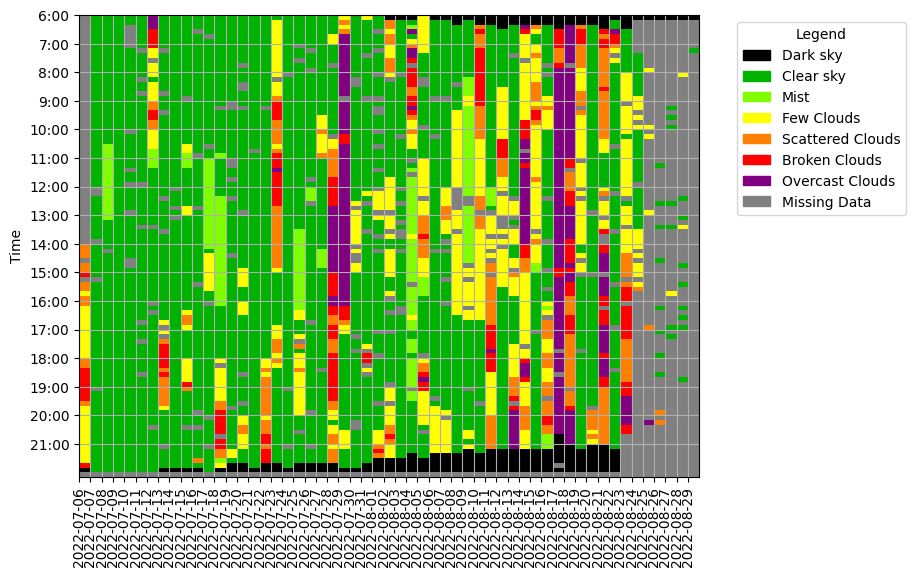

In [16]:
from matplotlib.patches import Patch
from matplotlib.ticker import FixedLocator, FuncFormatter, MultipleLocator

# Define the color table
color_table = mosaique_meteos(dirs_ann_files,user_labels)


# Define a custom mapping of colors to RGB values
color_mapping = {
    'n': [0, 0, 0],
    'c': [0, 0.7, 0],
    'm': [0.5, 1, 0],
    'f': [1, 1, 0],
    's': [1, 0.5, 0],
    'b': [1, 0, 0],
    'o': [0.5, 0, 0.5],
    'missing': [0.5, 0.5, 0.5]
}

# Convert color names to RGB values using the custom mapping
rgb_colors = np.array([[color_mapping[color] for color in row] for row in color_table])

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Create a pcolormesh plot using custom colors
cax = ax.pcolormesh(np.arange(rgb_colors.shape[1] + 1),
                    np.arange(rgb_colors.shape[0] + 1),
                    rgb_colors)

# Turn off axis labels
#ax.axis('off')

# Create a legend with custom color patches
legend_patches = [
    Patch(color=color_mapping['n'], label='Dark sky'),
    Patch(color=color_mapping['c'], label='Clear sky'),
    Patch(color=color_mapping['m'], label='Mist'),
    Patch(color=color_mapping['f'], label='Few Clouds'),
    Patch(color=color_mapping['s'], label='Scattered Clouds'),
    Patch(color=color_mapping['b'], label='Broken Clouds'),
    Patch(color=color_mapping['o'], label='Overcast Clouds'),
    Patch(color=color_mapping['missing'], label='Missing Data')
]

# Add the legend to the plot
ax.legend(handles=legend_patches, title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')

#hours = np.arange(6, 22, 10/60)
#hours = np.arange(6, 22, 2)  # Change the step to adjust the number of ticks
#ax.set_yticks(np.arange(len(hours)) + 0.5)
#ax.set_yticklabels([f'{int(h)}:{int((h % 1) * 60):02d}' for h in hours])
#ax.set_yticklabels([])




# Add y-axis ticks and labels for time from 6:00 to 22:00 with 10-minute intervals
#ax.set_yticks(np.arange(0.5, 16.5, 1))  # 16 rows from 6:00 to 22:00
#ax.set_yticklabels([f'{hour:02d}:{minute:02d}' for hour in range(6, 23) for minute in range(0, 60, 10)])

ytick_locations = np.arange(0, (22-6)*6, 6)
ytick_labels = [f'{int(hour/6+6)}:00' for hour in ytick_locations]
#print(ytick_locations)
#print(ytick_labels)
plt.yticks(ytick_locations, ytick_labels)
plt.ylabel('Time')

#ax.set_yticklabels([f'{int(h)}:00' for h in hours])
ax.invert_yaxis()

ax.set_xticks(np.arange(len(liste_dates)) + 0.5*0)
ax.set_xticklabels(liste_dates,rotation='vertical')

# Define custom minor tick locations for the x-axis
#yticks_minor = ytick_locations# np.arange(0.5, 10.5, 1)

# Define custom minor tick locations for the y-axis
#xticks_minor = np.arange(0, 11, 1)


ax.grid()

# Define custom minor tick locations for the y-axis
xticks_minor = np.arange(len(liste_dates)) + 0.5

# Show the plot
plt.show()


In [17]:
# Opening an annotation file that have been made
import os
import numpy as np

out_path = "/scratch/lpoughon/PolarizedDatabaseM/"
file_list = os.listdir(out_path)

# Filter files that match the pattern
filtered_files = [file for file in file_list if file.endswith('_raw_annotations.npy')]

# Sort the files by date
sorted_files = sorted(filtered_files)

# Initialize an empty list to store the loaded files
all_files = []

# Loop through the sorted files and concatenate them
for file_name in sorted_files:
    file_path = os.path.join(out_path, file_name)
    file = np.load(file_path, allow_pickle=True)
    all_files.append(file)

# Concatenate the loaded files along the desired axis
concatenated_data = np.concatenate(all_files, axis=0)

# Print or use the concatenated data as needed
print(concatenated_data)


[['2022-07-06T14-00-16' 's']
 ['2022-07-06T14-00-19' 's']
 ['2022-07-06T14-00-21' 's']
 ...
 ['2022-08-29T07-25-55' 'c']
 ['2022-08-29T07-25-57' 'c']
 ['2022-08-29T07-25-59' 'c']]


In [18]:
# Create a Pandas Dataframe

concatenated_data_transpose = concatenated_data.transpose()
df2 = pd.DataFrame({'Timestamp': concatenated_data_transpose[0], 'annotation':concatenated_data_transpose[1]})

#show the DataFrame
df2

,Timestamp,annotation
0,2022-07-06T14-00-16,s
1,2022-07-06T14-00-19,s
2,2022-07-06T14-00-21,s
3,2022-07-06T14-00-28,s
4,2022-07-06T14-00-31,s
...,...,...
39949,2022-08-29T07-25-50,c
39950,2022-08-29T07-25-53,c
39951,2022-08-29T07-25-55,c
39952,2022-08-29T07-25-57,c


In [19]:
# Merge two dataframe with based on the Timestamp
merged_df = pd.merge(df, df2, on = 'Timestamp')

In [20]:
# Sorting by the Timestamp to compare if it's well done
merged_df.sort_values(by = 'Sun_zenith_angle')

,Image_folder_path,Timestamp,Hour_Local,Minute_Local,Second_Local,Date,Sun_azimuth,Sun_zenith_angle,Sun_hour_angle,Sun_declination,Camera_exposure_time,Image_type,annotation
5735,2022-07-07/2022-07-07T13-40-35,2022-07-07T13-40-35,13,40,35,2022-07-07,177.838835,20.745404,-0.828742,67.447036,92.632,6,c
24109,2022-07-07/2022-07-07T13-40-37,2022-07-07T13-40-37,13,40,37,2022-07-07,177.838835,20.745404,-0.828742,67.447036,506.880,7,c
5861,2022-07-07/2022-07-07T13-40-33,2022-07-07T13-40-33,13,40,33,2022-07-07,177.838835,20.745404,-0.828742,67.447036,33.456,5,c
34545,2022-07-07/2022-07-07T13-40-39,2022-07-07T13-40-39,13,40,39,2022-07-07,177.838835,20.745404,-0.828742,67.447036,1000.032,8,c
24009,2022-07-07/2022-07-07T13-40-20,2022-07-07T13-40-20,13,40,20,2022-07-07,177.827977,20.745518,-0.832909,67.447035,4550.712,0,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23562,2022-08-28/2022-08-28T21-55-31,2022-08-28T21-55-31,21,55,31,2022-08-28,301.257586,106.684866,123.878050,80.505452,506.880,7,n
29708,2022-08-28/2022-08-28T21-55-43,2022-08-28T21-55-43,21,55,43,2022-08-28,301.260913,106.687462,123.882218,80.505456,49999.416,12,n
29414,2022-08-28/2022-08-28T21-55-40,2022-08-28T21-55-40,21,55,40,2022-08-28,301.260913,106.687462,123.882218,80.505456,25006.576,11,n
19003,2022-08-28/2022-08-28T21-55-45,2022-08-28T21-55-45,21,55,45,2022-08-28,301.260913,106.687462,123.882218,80.505456,100004.824,13,n


In [54]:
# Take the datas that has value 'c' on annotations
sky_types = ['n', 'c', 'm', 'f', 's', 'b', 'o']
for sky_type in sky_types:
    print(sky_type,end=" ")
    print(merged_df[merged_df['annotation']==sky_type].shape)


n (3450, 13)
c (23519, 13)
m (1312, 13)
f (5349, 13)
s (2543, 13)
b (1656, 13)
o (2125, 13)


# Make a new Data set with specific sky type
In this second part of the code, we define the dataset by its sky condition as bellow:
- 'n' = 'Dark sky'
- 'c' = 'Clear sky'
- 'm' = 'Mist'
- 'f' = 'Few Clouds'
- 's' = 'Scattered Clouds'
- 'b'= 'Broken Clouds'
- 'o' = 'Overcast Clouds'

In [43]:
class NewPolarizationDataset(Dataset):
    def __init__(self, data_dir, data_description_file, merged_df, transform=None, target_transform=None, sky_type=None):
        self.data_dir = data_dir
        self.data_description_file = pd.read_csv(os.path.join(data_dir, data_description_file)).sample(frac = 0.1, random_state=1)
        self.merged_df = merged_df
        self.sky_type = sky_type
        self.transform = transform
        self.target_transform = target_transform

        if sky_type:
            self.filtered_data = self.filter_by_sky_type(sky_type)
        else:
            self.filtered_data = self.data_description_file

    def filter_by_sky_type(self, sky_type):
        return self.merged_df[self.merged_df['annotation'] == sky_type]

    def __getitem__(self, idx):
        DoLP_exp = os.path.join(self.data_dir, self.filtered_data.iloc[idx, 0], 'AOP_B.npy')
        DoLP_simu = os.path.join(self.data_dir, self.filtered_data.iloc[idx, 0], 'AOP_s.npy')
        Sun_el = np.float32(90 - self.filtered_data.iloc[idx, 7])

        imageDoLP_exp = torch.from_numpy(np.load(DoLP_exp)).unsqueeze(0).float()
        imageDoLP_simu = torch.from_numpy(np.load(DoLP_simu)).unsqueeze(0).float()

        imageDoLP_exp = torch.nan_to_num(imageDoLP_exp)
        imageDoLP_simu = torch.nan_to_num(imageDoLP_simu)

        if self.transform:
            imageDoLP_exp = self.transform(imageDoLP_exp)
            imageDoLP_simu = self.transform(imageDoLP_simu)

        if self.target_transform:
            Sun_el = self.target_transform(Sun_el)

        return imageDoLP_exp, imageDoLP_simu, Sun_el

    def __len__(self):
        return len(self.filtered_data)


# Now we we randomly split the dataframe into two, for train and test

In [44]:
# We devide the whole dataset to 80 for training and evaluation, and 20 for test with specific sky type
df_80 = pd.read_csv(os.path.join(data_dir, data_description_file)).sample(frac = 0.75)
df_20 = df.drop(df_80.index)

# The file df2 is the DataFrame for the annotation, now we merge with df_80 and df_20 based on the timestamp
merged_df_80 = pd.merge(df_80, df2, on = 'Timestamp')
merged_df_20 = pd.merge(df_20, df2, on = 'Timestamp')

In [45]:
merged_df_80

,Image_folder_path,Timestamp,Hour_Local,Minute_Local,Second_Local,Date,Sun_azimuth,Sun_zenith_angle,Sun_hour_angle,Sun_declination,Camera_exposure_time,Image_type,annotation
0,2022-07-15/2022-07-15T08-21-17,2022-07-15T08-21-17,8,21,17,2022-07-15,79.789111,68.948261,-80.843482,68.486371,33.456,5,c
1,2022-07-17/2022-07-17T07-41-32,2022-07-17T07-41-32,7,41,32,2022-07-17,73.681106,76.266081,-90.880553,68.809445,506.880,7,c
2,2022-08-09/2022-08-09T07-03-40,2022-08-09T07-03-40,7,3,40,2022-08-09,71.542670,86.390635,-100.228489,74.147122,92.632,6,c
3,2022-07-08/2022-07-08T17-40-43,2022-07-08T17-40-43,17,40,43,2022-07-08,266.570433,52.644405,59.131668,67.578767,92.632,6,c
4,2022-08-22/2022-08-22T20-44-40,2022-08-22T20-44-40,20,44,40,2022-08-22,289.186540,93.173212,105.712284,78.409881,42326.000,0,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29960,2022-08-19/2022-08-19T07-24-24,2022-08-19T07-24-24,7,24,24,2022-08-19,77.610817,84.510628,-94.516515,77.229180,4550.712,1,s
29961,2022-08-18/2022-08-18T17-24-16,2022-08-18T17-24-16,17,24,16,2022-08-18,254.958378,56.213804,55.449267,77.039464,1138.112,0,s
29962,2022-07-24/2022-07-24T16-12-03,2022-07-24T16-12-03,16,12,3,2022-07-24,244.350459,38.666343,36.766072,70.215103,171.536,2,c
29963,2022-08-27/2022-08-27T13-25-09,2022-08-27T13-25-09,13,25,9,2022-08-27,173.319371,33.472720,-3.735336,80.027181,4550.712,1,c


In [46]:
merged_df_20

,Image_folder_path,Timestamp,Hour_Local,Minute_Local,Second_Local,Date,Sun_azimuth,Sun_zenith_angle,Sun_hour_angle,Sun_declination,Camera_exposure_time,Image_type,annotation
0,2022-08-14/2022-08-14T14-24-11,2022-08-14T14-24-11,14,24,11,2022-08-14,199.941246,30.318267,10.232656,75.732400,506.880,7,b
1,2022-08-17/2022-08-17T12-04-28,2022-08-17T12-04-28,12,4,28,2022-08-17,137.245226,36.654918,-24.616318,76.645638,506.880,7,o
2,2022-08-28/2022-08-28T09-05-10,2022-08-28T09-05-10,9,5,10,2022-08-28,97.651625,67.894903,-68.672973,80.315838,2282.224,0,c
3,2022-08-14/2022-08-14T20-03-54,2022-08-14T20-03-54,20,3,54,2022-08-14,283.763940,83.887945,95.012160,75.805779,4550.712,0,s
4,2022-07-15/2022-07-15T14-51-11,2022-07-15T14-51-11,14,51,11,2022-07-15,217.713538,25.845492,16.652156,68.528998,447.704,2,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2022-08-25/2022-08-25T17-55-16,2022-08-25T17-55-16,17,55,16,2022-08-25,259.373128,63.650744,63.642294,79.395462,506.880,7,s
9985,2022-08-16/2022-08-16T17-04-13,2022-08-16T17-04-13,17,4,13,2022-08-16,251.243701,52.204064,50.339545,76.393713,566.056,3,s
9986,2022-08-28/2022-08-28T08-55-10,2022-08-28T08-55-10,8,55,10,2022-08-28,95.852039,69.700763,-71.173508,80.313393,2282.224,0,c
9987,2022-08-24/2022-08-24T14-05-03,2022-08-24T14-05-03,14,5,3,2022-08-24,191.051833,32.708192,6.057461,78.995710,33.456,5,f


In [48]:
# Checking if they have same data (overlapping)
if merged_df_80.equals(merged_df_20):
    print("The data in merged_df_80 is the same as merged_df_20.")
else:
    print("The data in merged_df_80 is different from merged_df_20.")

The data in merged_df_80 is different from merged_df_20.


In [49]:
# We generate data set for train and test
train_dataset = NewPolarizationDataset(data_dir, data_description_file, merged_df_80, sky_type=None)
print(len(train_dataset))
#test_dataset = NewPolarizationDataset(data_dir, data_description_file, merged_df_20, sky_type='c')
#print(len(test_dataset))

3996


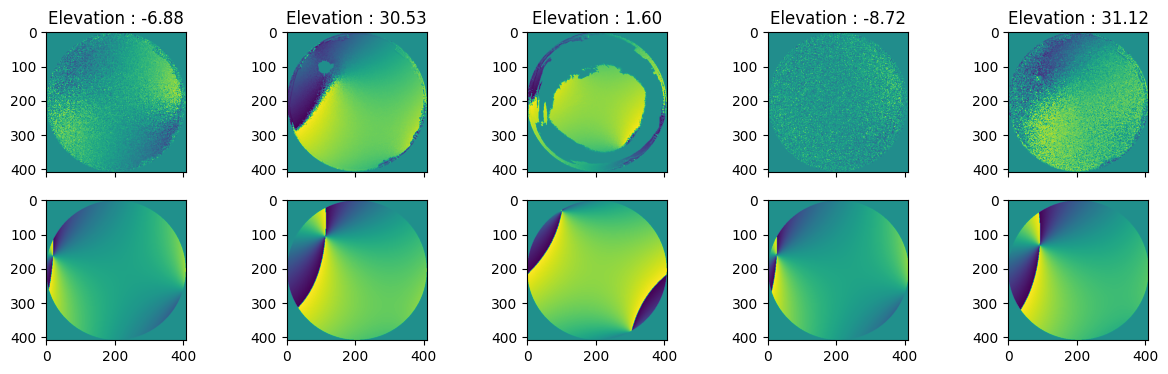

In [50]:
# Make the dataloader for the training
# Split data into train and train
train_size4 = int(0.8 * len(train_dataset))
test_size4 = len(train_dataset) - train_size4

# Generator : seed used to randomly split data into train and test set in a reproducible way
train_dataset4, test_dataset4 = random_split(train_dataset, [train_size4, test_size4], generator=torch.Generator().manual_seed(1))

trainloader4 = DataLoader(dataset=train_dataset4, batch_size=32, shuffle=True, num_workers=1)
testloader4 = DataLoader(dataset=test_dataset4, batch_size=32, shuffle=True, num_workers=1)

# Plot some examples from the new dataset (all sky type)
DoLP_exp_features, DoLP_simu_features, el_features = next(iter(trainloader4))

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(15,4))
for i in range(5):
    ax[0,i].imshow(DoLP_exp_features[i].squeeze())
    ax[1,i].imshow(DoLP_simu_features[i].squeeze())
    ax[0,i].set_title("Elevation : %.2f" % el_features[i].item())

In [36]:
# Train the model
# Train with same model
criterion = nn.MSELoss()
optimizer = optim.Adam(CNNnet.parameters(), lr=learning_rate, weight_decay=0.01)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0
best_test_loss = 1_000_000.


train_loss_list = []
test_loss_list = []
for t in range(num_epoch):
    print(f"Epoch [{t+1}/{num_epoch}]\n-------------------------------")
    loss = train_loop(trainloader4, CNNnet, criterion, optimizer, device)
    test_loss = test_loop(testloader4, CNNnet, criterion, device)
    train_loss_list.append(loss)
    test_loss_list.append(test_loss)
    
    # Track best performance, and save the model's state
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        #denoising_model_path = 'Model_saved_parameters/CNNnet_{}_{}'.format(timestamp, epoch_number)
        #torch.save(CNNnet_.state_dict(), denoising_model_path)
    epoch_number += 1

print("Done!")
plt.plot(range(num_epoch),train_loss_list, range(num_epoch), test_loss_list)

NameError: name 'CNNnet' is not defined

In [51]:
# Try all of the sky type and show the MSE errors

user_labels = {
    'n': 'dark_sky',
    'c': 'clear_sky',
    'm': 'Mist',
    'f': 'few_clouds',
    's': 'scattered_clouds',
    'b': 'broken_clouds',
    'o': 'overcast_clouds'
}

# Define the Mean Absoulte Error
mae_loss = nn.L1Loss()

def test_model_for_sky_type(sky_type, model, data_dir, data_description_file, merged_df_20, batch_size=8):
    # Create dataset and dataloader for the specified sky type
    dataset = NewPolarizationDataset(data_dir, data_description_file, merged_df_20, sky_type=sky_type)
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)

    # Get a batch of data
    DoLP_exp_features, DoLP_simu_features, el_features = next(iter(test_loader))
    DoLP_exp_features = DoLP_exp_features.to(device)

    # Plot the images
    fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(15, 4))
    for i in range(5):
        ax[0, i].imshow(DoLP_exp_features[i].squeeze().cpu())
        ax[1, i].imshow(DoLP_simu_features[i].squeeze())
        ax[0, i].set_title("Elevation: {:.2f}\nElevation_nn: {:.2f}".format(el_features[i].item(), model(DoLP_exp_features)[i].item()))
    plt.show()

    # Calculate the MSE Error
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predicted_sun_elevation = model(DoLP_exp_features).squeeze().cpu()

    # Ensure the target size has the same shape as the predicted size
    target_sun_elevation = el_features.cpu().squeeze()

    # Calculate Mean Absolute Error
    mse = mae_loss(predicted_sun_elevation, target_sun_elevation)
    print(f"Data Lengths for Sky Type on Test Set '{user_labels.get(sky_type, 'Unknown')}': {len(dataset)}")
    print(f"Mean Absolute Error on Test Set for Sky Type '{user_labels.get(sky_type, 'Unknown')}': {mse.item()}")

# Try to all the sky condition
sky_types = ['n', 'c', 'm', 'f', 's', 'b', 'o']
for sky_type in sky_types:
    test_model_for_sky_type(sky_type, CNNnet, data_dir, data_description_file, merged_df_20)


NameError: name 'CNNnet' is not defined